## Custom loss approach
In the given notebook, we are going to try how would perform in our task an xgboost model with an objective tailored to our needs.


Since XGBoost is a method that is capable of customizing a loss function, we decided to write our own function to maximize the score in the project. We not only need to identify customers in our dataset that used the offer, but also minimize number of used features.

### `scale_pos_weights`
Let us investigate how the performance of model in our task depends on the value of hyperparameter `scale_pos_weights`

In [2]:
import sys
sys.path.append('..')

from metrics import default_competition_metric
from metrics import make_competition_scorer


import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.preprocessing import StandardScaler

np.random.seed(44)

In [3]:
X_train = np.load('../../data/x_train.npy')
y_train = np.load('../../data/y_train.npy')
X_val = np.load('../../data/x_val.npy')
y_val = np.load('../../data/y_val.npy')

In [4]:
features = [100, 101, 102, 103, 104, 105]

In [5]:
xgboosts = []
scale_pos_weights = np.linspace(0, 1, 20)
cv_folds = 10

scores = np.zeros((len(scale_pos_weights), cv_folds))


for i, scale in enumerate(scale_pos_weights):
    
    idx = np.array(range(X_train.shape[0]))
    np.random.shuffle(idx)
    
    print('Scale:', scale)
    
    idx = idx % cv_folds
    for j in range(cv_folds):
        X_train_cv = X_train[idx != j]
        y_train_cv = y_train[idx != j]
        X_val_cv = X_train[idx == j]
        y_val_cv = y_train[idx == j]
        
        xgboost = xgb.XGBClassifier(
            n_estimators=1000,
            max_depth=3,
            learning_rate=0.1,
            subsample=0.5,
            colsample_bytree=0.5,
            scale_pos_weight=scale,
            n_jobs=4,
            random_state=44
        )
        xgboost.fit(X_train_cv, y_train_cv)
        xgboosts.append(xgboost)
        
        y_pred = xgboost.predict_proba(X_val_cv)[:, 1]
        score = default_competition_metric(y_val_cv,y_pred, k = len(features), y_pred_proba=y_pred)
        scores[i, j] = score
    print("Average score:", np.mean(scores[i]))

Scale: 0.0
Average score: 3800.0
Scale: 0.05263157894736842
Average score: 5737.5
Scale: 0.10526315789473684
Average score: 5812.5
Scale: 0.15789473684210525
Average score: 5787.5
Scale: 0.21052631578947367
Average score: 5862.5
Scale: 0.2631578947368421
Average score: 6000.0
Scale: 0.3157894736842105
Average score: 5837.5
Scale: 0.3684210526315789
Average score: 5850.0
Scale: 0.42105263157894735
Average score: 5900.0
Scale: 0.47368421052631576
Average score: 6012.5
Scale: 0.5263157894736842
Average score: 5887.5
Scale: 0.5789473684210527
Average score: 5737.5
Scale: 0.631578947368421
Average score: 5937.5
Scale: 0.6842105263157894
Average score: 5937.5
Scale: 0.7368421052631579
Average score: 6175.0
Scale: 0.7894736842105263
Average score: 5900.0
Scale: 0.8421052631578947
Average score: 5875.0
Scale: 0.894736842105263
Average score: 5900.0
Scale: 0.9473684210526315
Average score: 5787.5
Scale: 1.0
Average score: 5862.5


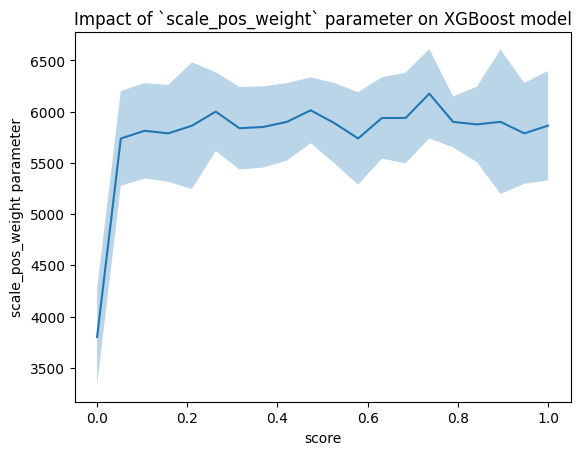

In [6]:
import matplotlib.pyplot as plt

plt.title("Impact of `scale_pos_weight` parameter on XGBoost model")
plt.ylabel("scale_pos_weight parameter")
plt.xlabel("score")

import seaborn as sns
plt.plot(scale_pos_weights, np.mean(scores, axis=1))
plt.fill_between(scale_pos_weights, np.mean(scores, axis=1) - np.std(scores, axis=1), np.mean(scores, axis=1) + np.std(scores, axis=1), alpha=0.3)

it looks that this parameter has little impact on the model predictions. There is negligible difference between runs